# DD2367 - Programming Assignment II: Quantum Circuits and Gates - Bell's Circuit and SWAP Test #

Authors: Scott McHaffie, Jai Iyer, Venkatesh Elayaraja

# Task 1 - State‑Vector Quantum Computer Simulator  #

## 1.1 - State‑vector representation ##

In [1]:
import numpy as np

DTYPE = np.complex128

def ket00():
    """Return |00> as a length‑4 complex column vector."""
    v = np.zeros(4, dtype=DTYPE)
    v[0] = 1.0
    return v

def normalize(v: np.ndarray) -> np.ndarray:
    n = np.linalg.norm(v)
    if n == 0:
        raise ValueError("Zero vector cannot be normalized.")
    return v / n

# Example
psi = ket00()
print (psi)
assert np.isclose(np.linalg.norm(psi), 1.0), "State is not normalized!"

[1.+0.j 0.+0.j 0.+0.j 0.+0.j]


For a 2-qubit system, the computational basis is ordered as $|q_0q_1\rangle$, with $q_0$ as the most significant qubit (MSB). This maps the bitstrings to indices as follows: $|00\rangle \to 0$, $|01\rangle \to 1$, $|10\rangle \to 2$, and $|11\rangle \to 3$.

## 1.2 - Quantum gate implementation ##

In [2]:
# 1‑qubit and 2‑qubit gate definitions (matrix form)
I2 = np.array([[1, 0], [0, 1]], dtype=DTYPE)
H  = (1/np.sqrt(2)) * np.array([[1, 1], [1, -1]], dtype=DTYPE)

# CNOT with control = q0 (MSB), target = q1 (LSB) in basis |q0 q1>
CNOT_01 = np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,0,1],
    [0,0,1,0]
], dtype=DTYPE)

# Expand a 1‑qubit unitary U to a 2‑qubit operator acting on target qubit t in |q0 q1> order
# t = 0 applies to q0 (MSB); t = 1 applies to q1 (LSB)

def expand_1q(U: np.ndarray, t: int) -> np.ndarray:
    if t == 0:   # act on q0 (MSB)
        return np.kron(U, I2) # kronecker product is the tensor product
    elif t == 1: # act on q1 (LSB)
        return np.kron(I2, U)
    else:
        raise ValueError("target index must be 0 or 1")

# Apply a gate matrix to a state vector

def apply(U: np.ndarray, psi: np.ndarray) -> np.ndarray:
    return U @ psi

# Quick unit tests
assert np.allclose(H.conj().T @ H, I2)
assert np.allclose(CNOT_01.conj().T @ CNOT_01, np.eye(4))

`CNOT_01` matrix implements a controlled-NOT gate with **qubit `q0` as the control** and **qubit `q1` as the target**.

The four basis states of the 2-qubit system are ordered as follows:

* $|00\rangle = [1, 0, 0, 0]^T$
* $|01\rangle = [0, 1, 0, 0]^T$
* $|10\rangle = [0, 0, 1, 0]^T$
* $|11\rangle = [0, 0, 0, 1]^T$

A CNOT gate flips the target qubit if and only if the control qubit is $|1\rangle$.

* **When control `q0` is 0:**
    * $CNOT_{01} |00\rangle = |00\rangle$
    * $CNOT_{01} |01\rangle = |01\rangle$
    In both cases, the target qubit `q1` remains unchanged, which is the correct behavior.

* **When control `q0` is 1:**
    * $CNOT_{01} |10\rangle = [0, 0, 0, 1]^T = |11\rangle$
    * $CNOT_{01} |11\rangle = [0, 0, 1, 0]^T = |10\rangle$
    In both cases, the target qubit `q1` is flipped.

## 1.3 - Circuit simulation: Bell state ##

In [3]:
def bell_state() -> np.ndarray:
    psi = ket00()
    # H on q0 (MSB), then CNOT(control=q0, target=q1)
    psi = apply(expand_1q(H, t=0), psi)
    psi = apply(CNOT_01, psi)
    return normalize(psi)

psi_bell = bell_state()
print("Bell state vector:", np.round(psi_bell, 6))
# Expected amplitudes (up to a global phase): [1/√2, 0, 0, 1/√2]
print (psi_bell)

Bell state vector: [0.707107+0.j 0.      +0.j 0.      +0.j 0.707107+0.j]
[0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]



The resulting state vector confirms the successful creation of the Bell state $|\Phi^+\rangle$.

The theoretical Bell state is given by the formula $|\Phi^+\rangle = \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$.

Its vector representation:

  * The basis state $|00\rangle$ corresponds to the vector $[1, 0, 0, 0]^T$.
  * The basis state $|11\rangle$ corresponds to the vector $[0, 0, 0, 1]^T$.
  * Therefore, the state $|\Phi^+\rangle$ is $\frac{1}{\sqrt{2}}([1, 0, 0, 0]^T + [0, 0, 0, 1]^T) = \frac{1}{\sqrt{2}}[1, 0, 0, 1]^T$.

Since $\frac{1}{\sqrt{2}} \approx 0.707107$, the expected vector is approximately `[0.707107, 0, 0, 0.707107]` which is what we can see in the above print statement.

## 1.4 - Output, verification, and circle‑plot comparison ##

{'00': 4983, '01': 0, '10': 0, '11': 5017}


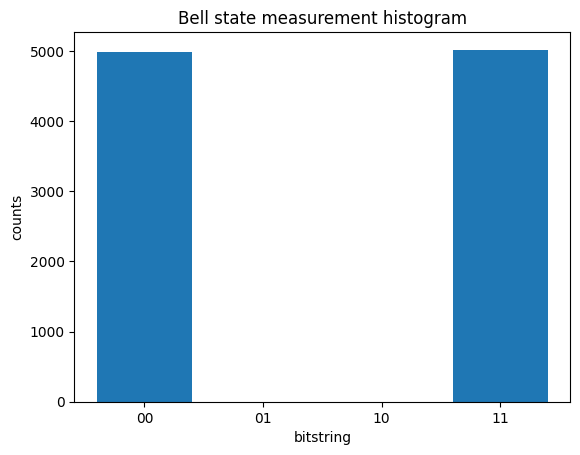

In [4]:
import matplotlib.pyplot as plt

BITSTR = ["00","01","10","11"]

def sample_bitstrings(psi: np.ndarray, shots: int = 10_000, seed: int = 7):
    rng = np.random.default_rng(seed)
    probs = np.abs(psi)**2
    idx = rng.choice(4, size=shots, p=probs)
    return idx

# Sample from Bell state
shots = 10_000
idx = sample_bitstrings(psi_bell, shots=shots)

# Make histogram
counts = {b: int(np.sum(idx == i)) for i, b in enumerate(BITSTR)}
print(counts)
plt.bar(counts.keys(), counts.values())
plt.xlabel("bitstring"); plt.ylabel("counts"); plt.title("Bell state measurement histogram")
plt.show()

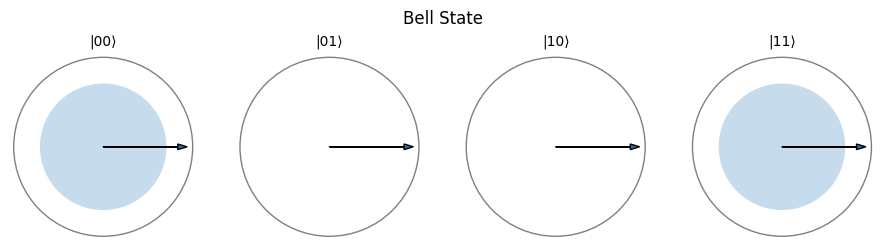

In [5]:
from circleNotationClass import QubitSystem

QubitSystem(psi_bell, label="Bell State").viz_circle()

# Task 2 - State‑Vector SWAP Test  #

Initial state:
 [0.11043153+0.j 0.99388373+0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]


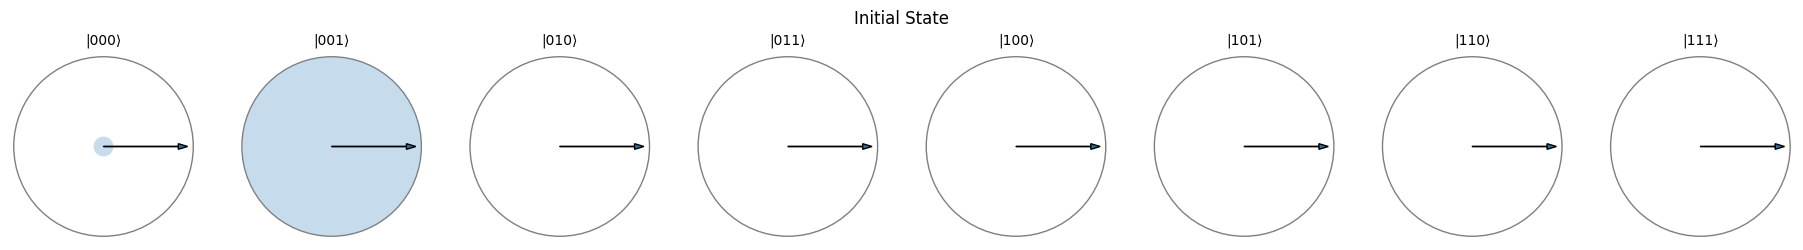

H on q_ancilla:
 [0.07808688+0.j 0.70278193+0.j 0.        +0.j 0.        +0.j
 0.07808688+0.j 0.70278193+0.j 0.        +0.j 0.        +0.j]


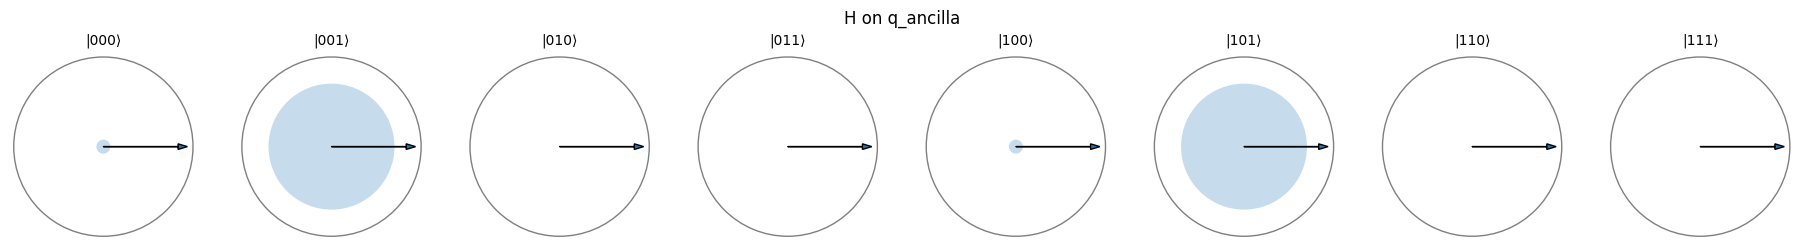

CSWAP with q_ancillas as control:
 [0.07808688+0.j 0.70278193+0.j 0.        +0.j 0.        +0.j
 0.07808688+0.j 0.        +0.j 0.70278193+0.j 0.        +0.j]


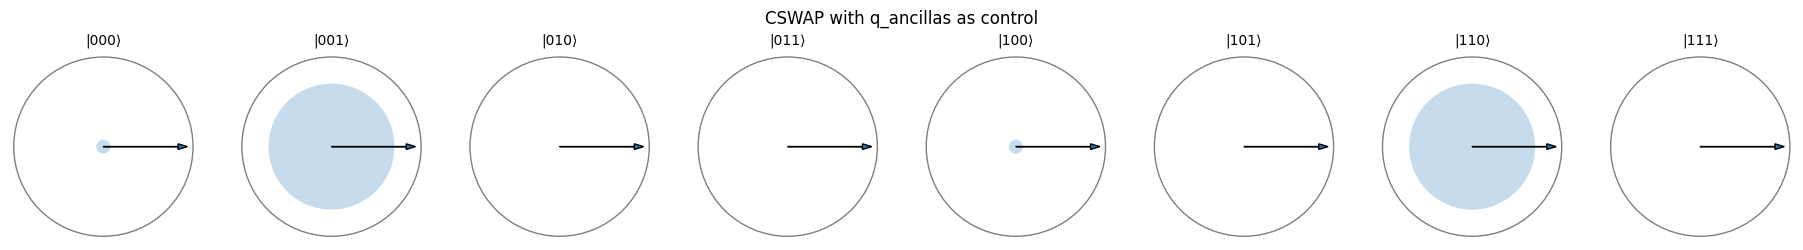

H on q_ancilla (again): [ 1.10431526e-01+0.j  4.96941867e-01+0.j  4.96941867e-01+0.j
  0.00000000e+00+0.j  3.17435423e-19+0.j  4.96941867e-01+0.j
 -4.96941867e-01+0.j  0.00000000e+00+0.j]


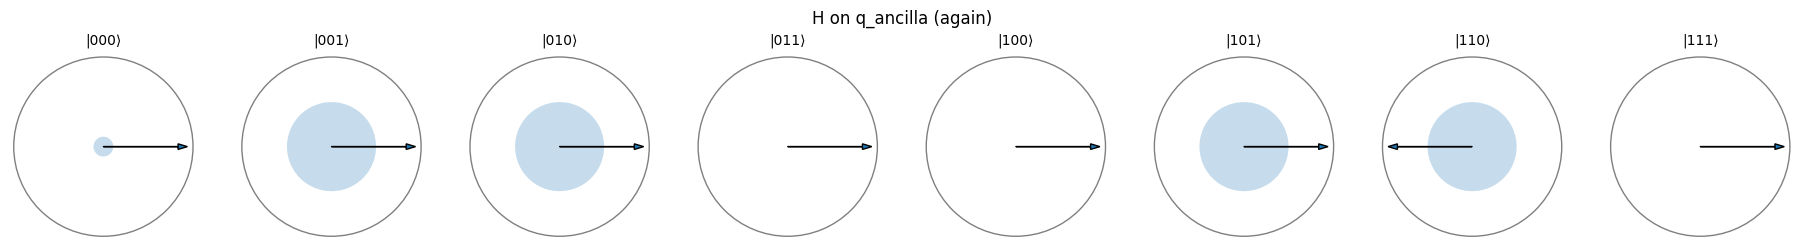

SWAP Test Fidelity: 0.012195121951219967
Exact Fidelity: 0.012195121951219513


In [195]:
def expand_1q_n(U: np.ndarray, t: int, n: int) -> np.ndarray:
    op = np.array([[1]], dtype=U.dtype)
    for q in range(n):
        op = np.kron(op, U if q == t else I2)
    return op


# Apply CSWAP, with ancilla as control
P0 = np.array([[1,0],[0,0]], dtype=DTYPE)  # |0><0| on ancilla
P1 = np.array([[0,0],[0,1]], dtype=DTYPE)  # |1><1| on ancilla
SWAP_A0_B0 = np.array([
    [1,0,0,0],
    [0,0,1,0],
    [0,1,0,0],
    [0,0,0,1]
], dtype=DTYPE)  # SWAP on A0 and B0
CSWAP = (np.kron(P0, np.eye(4)) + np.kron(P1, SWAP_A0_B0)) # CSWAP with ancilla as control

# function to easily call three different 
def Task2_automator(Psi: np.ndarray, Phi: np.ndarray) -> None:
    # important! remember to normalize
    Psi = Psi/np.linalg.norm(Psi); Phi = Phi/np.linalg.norm(Phi)

    # initial state (|output A0 B0>)                                #   q_ancilla x q_A0 x q_B0
    init = np.kron(np.array([1,0], dtype=DTYPE), np.kron(Psi, Phi))  # |0>_output ⊗ |ψ>_A ⊗ |φ>_B
    print ("Initial state:\n", init)
    QubitSystem(init, label="Initial State").viz_circle()

    # Hs
    U_Ho = expand_1q_n(H, t=0, n=3)
    state = U_Ho @ init
    print("H on q_ancilla:\n", state)
    QubitSystem(state, label="H on q_ancilla").viz_circle()


    state = CSWAP @ state
    print("CSWAP with q_ancillas as control:\n", state)
    QubitSystem(state, label="CSWAP with q_ancillas as control").viz_circle()

    state = U_Ho @ state
    print("H on q_ancilla (again):", state)
    QubitSystem(state, label="H on q_ancilla (again)").viz_circle()

    # readout and fidelity from outer bit
    probs = np.abs(state)**2
    prob_1 = probs[4:].sum()   # indices with output=1
    F_hat = 1 - 2*prob_1
    print ("SWAP Test Fidelity:", F_hat)

    # inner product (exact fidelity check)
    F_exact = float(np.abs(np.vdot(psi/np.linalg.norm(psi), phi/np.linalg.norm(phi)))**2)
    print ("Exact Fidelity:", F_exact)

    return


# initialize phi
psi = [1, 0]
phi = [0.1, 0.9]

Task2_automator(psi, phi)


# Bonus Tasks - Quantum State Comparison with the Multiqubit SWAP Test #

## B.1 - Basis vs $|5\rangle$: design, simulate, evaluate ##

In [212]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer

def statevector_from_aer(circ: QuantumCircuit) -> np.ndarray:
    backend = Aer.get_backend("aer_simulator_statevector")
    tqc = transpile(circ, backend)
    result = backend.run(tqc).result()
    return np.asarray(result.get_statevector(tqc), dtype=np.complex128)


Rqc = QuantumCircuit(3, name="R")
Rqc.x(0); Rqc.x(2)
# Rqc.save_statevector()
# Rqc.draw(output="mpl")

# Rsv = statevector_from_aer(Rqc)
# QubitSystem(Rsv, label="|5> Reference State").viz_circle()


Lqc = QuantumCircuit(3, name="L")
# Lqc.x(0)
# Lqc.x(1)
# Lqc.x(2)
# Lqc.save_statevector()

# Lsv = statevector_from_aer(Lqc)
# QubitSystem(Lsv, label="L Random State").viz_circle()

STqc = Rqc.tensor(Lqc)
# STqc.save_statevector()
# STsv = statevector_from_aer(STqc)
# QubitSystem(STsv, label="Connected Registers").viz_circle()

Oqc = QuantumCircuit(1, 1, name="Output")
STqc = STqc.tensor(Oqc)

# apply Hadamard to control
STqc.h(0)

# we want to build a SWAP gate with three cx gates
for i in range (1, 4):
    STqc.ccx(0, i, i+3)
    STqc.ccx(0, i+3, i)
    STqc.ccx(0, i, i+3)

# apply Hadamard again
STqc.h(0)

STqc.measure(0, 0)

# showing circle plots
# STqc.save_statevector()
# STsv = statevector_from_aer(STqc)
# QubitSystem(STsv, label="Connected Registers").viz_circle()







In [211]:
# running multiple shots and finding fidelities
from qiskit.primitives import BackendSamplerV2
from qiskit_aer import AerSimulator

sim_resultsST = BackendSamplerV2(backend=AerSimulator()).run([STqc], shots=10_000).result()
sim_countsST = sim_resultsST[0].data.c.get_counts()
sim_totalST = sum(sim_countsST.values())
sim_probsST = {bitstr: count / sim_totalST for bitstr, count in sim_countsST.items()}

print (sim_probsST)

sim_prob1ST = sim_probsST.get('1', 0.0)


print (1.0 - 2*sim_prob1ST)

# print (sim_countsST)




{'1': 0.4945, '0': 0.5055}
0.01100000000000001


## B.2 - Introducing superposition ##

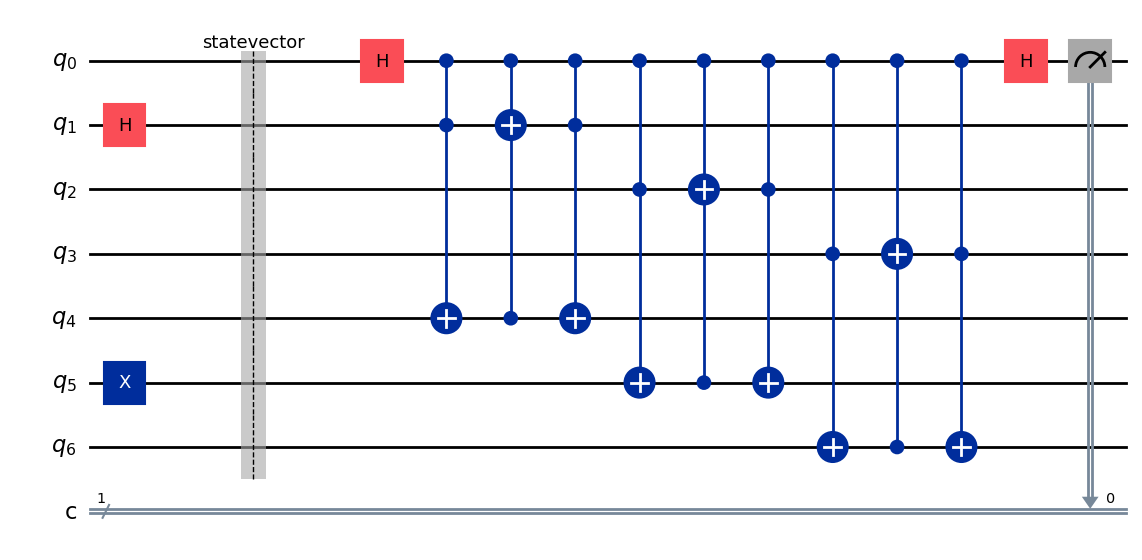

In [292]:
def init_qc(k: int):
    
    iRqc = QuantumCircuit(3, name="R")

    # specify state of R register based on k (input)
    binary_k = bin(k)[2:]
    binary_k = binary_k[::-1]
    for bin_val_idx in range(0, len(binary_k)):
        if binary_k[bin_val_idx] == '1':
            iRqc.x(bin_val_idx)
    
    # iRqc.save_statevector()
    # iRsv = statevector_from_aer(iRqc)
    # QubitSystem(iRsv, label="Connected Registers").viz_circle()

    # L register initialisation
    iLqc = QuantumCircuit(3, name="L")
    iLqc.h(0)

    # Tensor product of L & R registers (6-qubits)
    iSTqc = iRqc.tensor(iLqc)

    # Control Qubit & Classical Bit initialisation
    iOqc = QuantumCircuit(1, 1, name="Output")

    # Full tensor product (7-qubits)
    iSTqc = iSTqc.tensor(iOqc)

    iSTqc.save_statevector()
    iSTsv = statevector_from_aer(iSTqc)
    # QubitSystem(iSTsv, label="Connected Registers").viz_circle()


    # FIDELITY SWAP TEST
    # apply Hadamard to control
    iSTqc.h(0)

    # we want to build a SWAP gate with three cx gates
    for i in range (1, 4):
        iSTqc.ccx(0, i, i+3)
        iSTqc.ccx(0, i+3, i)
        iSTqc.ccx(0, i, i+3)

    # apply Hadamard again
    iSTqc.h(0)

    # Measure output qubit
    # iSTqc.measure(0, 0)
    

    return iSTqc




STqc5 = init_qc(2)
STqc5.measure(0, 0)
STqc5.draw("mpl")
# plt.show()




# print ("fidelity:", fc(STqc5, 10_000))




In [293]:

def fc(qc, sample_shots):
    sim_results = BackendSamplerV2(backend=AerSimulator()).run([qc], shots=sample_shots).result()
    sim_counts = sim_results[0].data.c.get_counts()
    sim_total = sum(sim_counts.values())
    sim_probs = {bitstr: count / sim_total for bitstr, count in sim_counts.items()}

    sim_probs1 = sim_probs.get('1', 0.0)

    return (1.0 - 2*sim_probs1)

B2fc = np.zeros(8)
for i in range(0, 8):
    B2qc = init_qc(i)
    B2qc.measure(0, 0)

    B2fc[i] = fc(B2qc, 10_000)

STqc5 = init_qc(2)
STqc5.measure(0, 0)

# print ("fidelity:", fc(STqc5, 10_000))

print ("Fidelity:", B2fc)




Fidelity: [ 0.5144  0.5    -0.003  -0.007   0.001   0.0306 -0.0096  0.0072]


# Generative AI Disclosure #

We used ChatGPT-5 and ChatGPT-4 for AI assistance during this assignment. A breakdown of the usage per task is shown below:

1. Task 1: 

2. Task 2: 

3. B.1: 

4. B.2: